# Демонстрация финализации и калибровки модели

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import target_dist, AutoTrees, base_pipe, FinalModel, RegressionMetrics

In [4]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('catboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.3.4
numpy:  1.22.2
scipy:  1.7.3
sklearn:  1.1.3
catboost:  1.0.4
matplotlib:  3.7.0
autobinary:  1.0.9


In [5]:
sample = pd.read_csv('../data/train_houseprice.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [6]:
num_columns = [
    'LotArea', 'LotFrontage', 'TotalBsmtSF', 'PoolArea', 'FullBath'
]

cat_columns = [
    'BldgType', 'CentralAir', 'GarageQual', 'Fence', 'SaleType'
]

target = ['SalePrice']

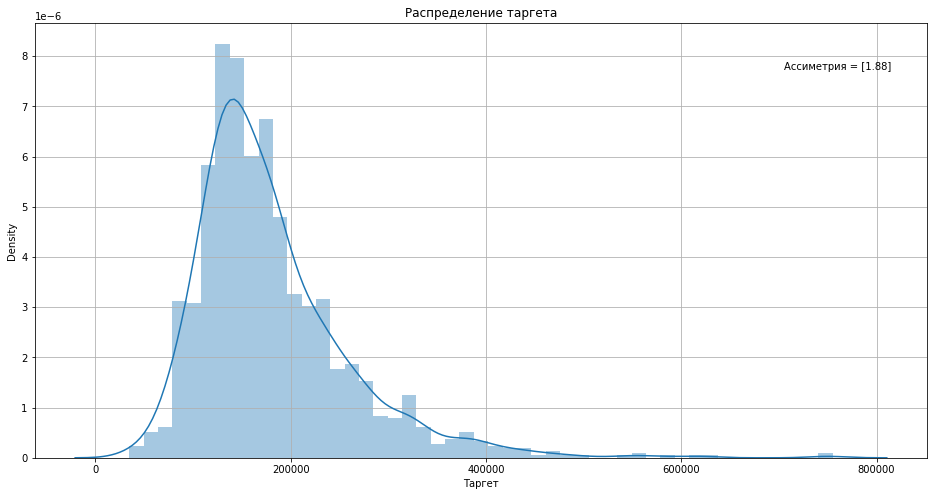

In [7]:
# График распределения непрерывной целевой переменной

target_dist(sample,target)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    random_state=42
)

In [9]:
params = {
    'learning_rate':0.01,
    'iterations':1000,
    'subsample':0.9,
    'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'MAPE',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'MAPE',
    'custom_metric':'MAE',
    'verbose':200}

## Обучение и калибровка по двум сценариям:
1) Если нам нужно и обучить и откалиброваться передаем на вход класса:
    * base_pipe - пайплайн обработки
    * num_columns / cat_columns - количественные и категориальные переменные
    * model_type - тип алгоритма
    * model_params - параметры алгоритма
    * task_type - тип задачи
    
2) Если у нас есть модель и нам нужно только откалиброваться:
    * prep_pipe_final - обученный пайплайн обработки
    * model_final - обученный алгоритм
    * num_columns / cat_columns - количественные и категориальные переменные
    * task_type - тип задачи

#### Сценарий №1

In [10]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=None,
                    model_final=None,
    
                    base_pipe=base_pipe,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type='catboost',
                    model_params=params,
                    task_type='regression')

In [11]:
# Обучение финальной соло модели

final_model.fit(X_train,y_train)

Определены количественные и категориальные переменные!
0:	learn: 0.2929242	total: 54.4ms	remaining: 54.3s
200:	learn: 0.2575769	total: 211ms	remaining: 840ms
400:	learn: 0.2429574	total: 348ms	remaining: 520ms
600:	learn: 0.2358789	total: 481ms	remaining: 319ms
800:	learn: 0.2304570	total: 609ms	remaining: 151ms
999:	learn: 0.2276552	total: 745ms	remaining: 0us


'Пайплайн и модель обучены!'

#### Сценарий №2

In [12]:
# Подгружаем трансформер факторов и модель

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

prep_pipe.fit(X_train,y_train)

# создаем экземпляр класса LightGBM
catb_model = ctb.CatBoostRegressor(**params)

catb_model.fit(prep_pipe.transform(X_train),y_train)

Определены количественные и категориальные переменные!
0:	learn: 0.2929242	total: 772us	remaining: 772ms
200:	learn: 0.2575769	total: 134ms	remaining: 531ms
400:	learn: 0.2429574	total: 257ms	remaining: 384ms
600:	learn: 0.2358789	total: 386ms	remaining: 256ms
800:	learn: 0.2304570	total: 518ms	remaining: 129ms
999:	learn: 0.2276552	total: 654ms	remaining: 0us


In [13]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=prep_pipe,
                    model_final=catb_model,
    
                    base_pipe=None,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type=None,
                    model_params=None,
                    task_type='regression')

In [14]:
# Проверка обучения финальной соло модели

final_model.fit(X_train,y_train)

Модель обучена! Доступны только метрики и калибровка!


### Отрисовка метрики  и получение предсказаний

In [15]:
# Если хотим проскорить одну из выборок

train_scores = final_model.predict(X_train)
val_scores = final_model.predict(X_val)

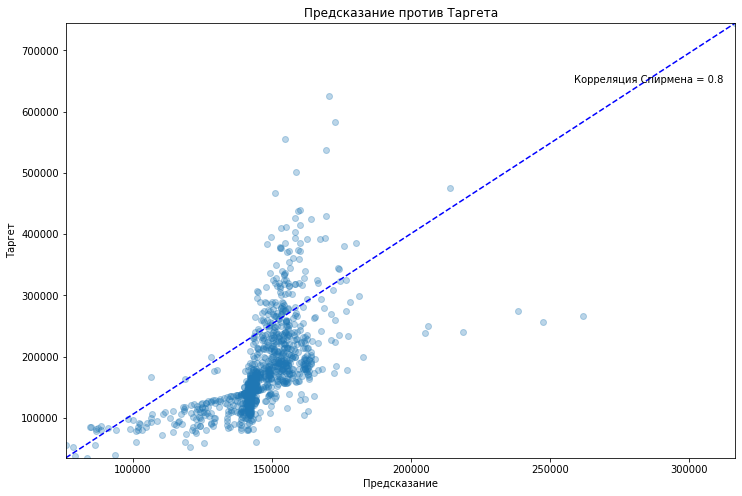

In [16]:
# Диаграмма рассеивания (target vs prediction), Корреляция Спирмена для трейна

final_model.plot_prediction(X_train, y_train)

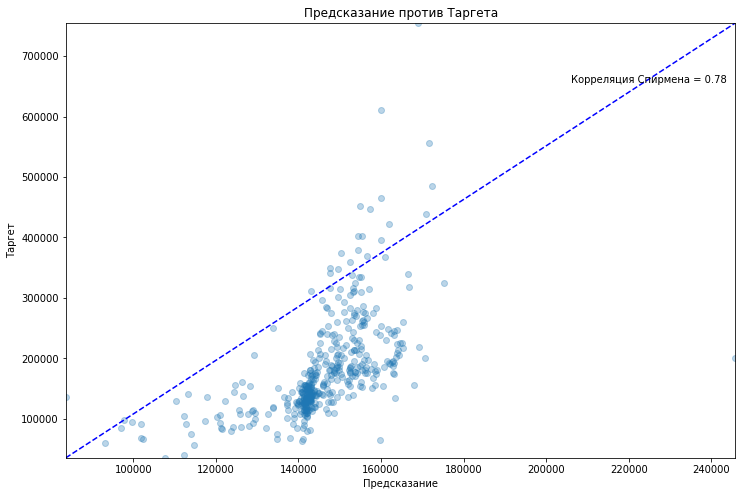

In [17]:
# Диаграмма рассеивания (target vs prediction), Корреляция Спирмена для теста

final_model.plot_prediction(X_val, y_val)

Всего записей в выборке:  1022
----------
Минимальное значение таргета: 34 900 
Максимальное значение таргета: 745 000


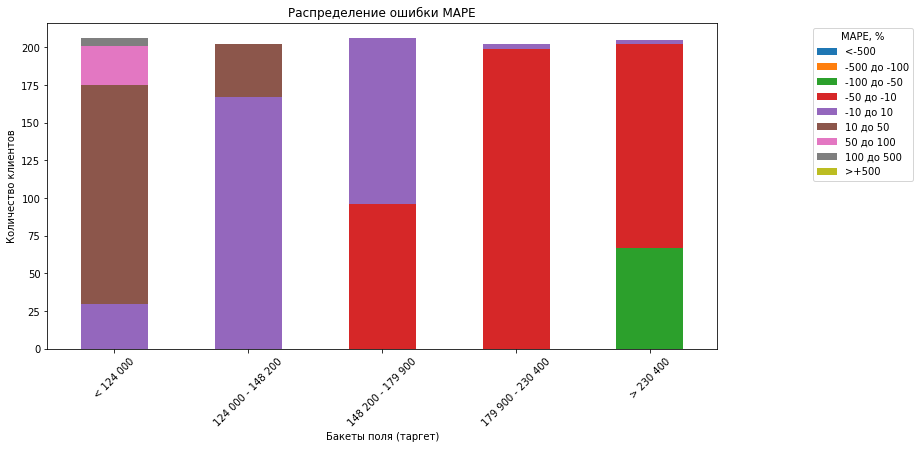

,target,target_range,prediction,mape,mape_range
0,174000,148 200 - 179 900,"147,715.20",-15.11,-50 до -10
1,145000,124 000 - 148 200,"141,062.80",-2.72,-10 до 10
2,215200,179 900 - 230 400,"155,630.38",-27.68,-50 до -10
3,320000,> 230 400,"151,252.15",-52.73,-100 до -50
4,212000,179 900 - 230 400,"157,883.12",-25.53,-50 до -10
...,...,...,...,...,...
1017,176432,148 200 - 179 900,"148,941.13",-15.58,-50 до -10
1018,135000,124 000 - 148 200,"151,429.52",12.17,10 до 50
1019,115000,< 124 000,"141,773.85",23.28,10 до 50
1020,189950,179 900 - 230 400,"142,087.28",-25.20,-50 до -10


In [18]:
# Метрика MAPE по бинам для трейна

mape_tr_table = final_model.metric_bin(X_train, y_train, 5, 'mape')
mape_tr_table

Всего записей в выборке:  438
----------
Минимальное значение таргета: 35 311 
Максимальное значение таргета: 755 000


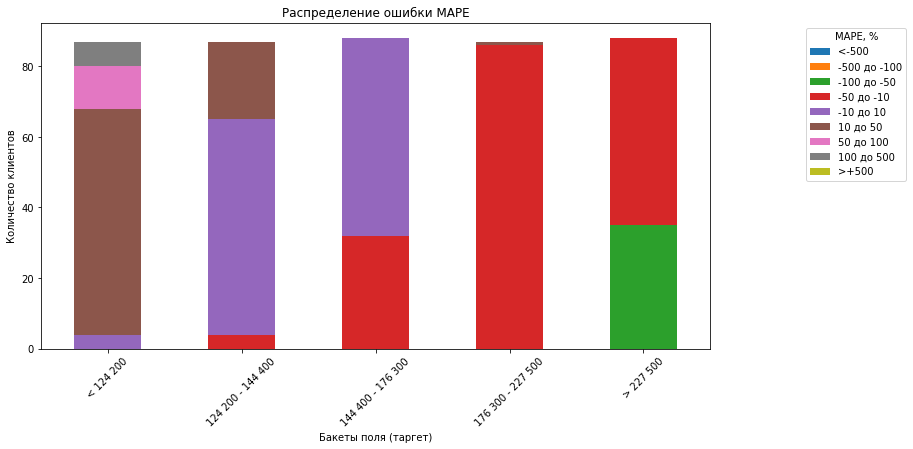

,target,target_range,prediction,mape,mape_range
0,154500,144 400 - 176 300,"141,763.42",-8.24,-10 до 10
1,325000,> 227 500,"153,676.84",-52.71,-100 до -50
2,115000,< 124 200,"142,453.28",23.87,10 до 50
3,159000,144 400 - 176 300,"146,948.43",-7.58,-10 до 10
4,315500,> 227 500,"153,218.09",-51.44,-100 до -50
...,...,...,...,...,...
433,139000,124 200 - 144 400,"141,988.21",2.15,-10 до 10
434,126175,124 200 - 144 400,"139,658.28",10.69,10 до 50
435,205950,176 300 - 227 500,"149,288.30",-27.51,-50 до -10
436,110000,< 124 200,"148,597.66",35.09,10 до 50


In [19]:
# Метрика MAPE по бинам для теста

mape_te_table = final_model.metric_bin(X_val, y_val, 5, 'mape')
mape_te_table

Всего записей в выборке:  1022
----------
Минимальное значение таргета: 34 900 
Максимальное значение таргета: 745 000


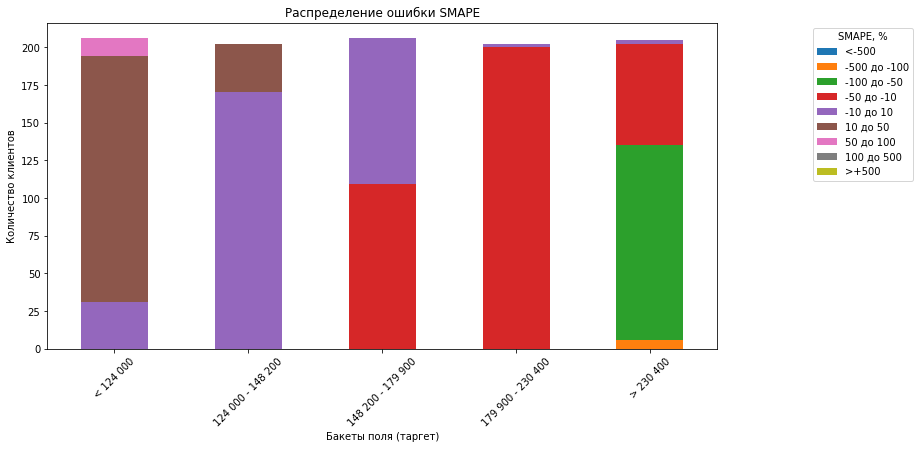

,target,target_range,prediction,smape,smape_range
0,174000,148 200 - 179 900,"147,715.20",-16.34,-50 до -10
1,145000,124 000 - 148 200,"141,062.80",-2.75,-10 до 10
2,215200,179 900 - 230 400,"155,630.38",-32.13,-50 до -10
3,320000,> 230 400,"151,252.15",-71.62,-100 до -50
4,212000,179 900 - 230 400,"157,883.12",-29.26,-50 до -10
...,...,...,...,...,...
1017,176432,148 200 - 179 900,"148,941.13",-16.90,-50 до -10
1018,135000,124 000 - 148 200,"151,429.52",11.47,10 до 50
1019,115000,< 124 000,"141,773.85",20.85,10 до 50
1020,189950,179 900 - 230 400,"142,087.28",-28.83,-50 до -10


In [20]:
# Метрика SMAPE по бинам для трейна

smape_tr_table = final_model.metric_bin(X_train, y_train, 5, 'smape')
smape_tr_table

Всего записей в выборке:  438
----------
Минимальное значение таргета: 35 311 
Максимальное значение таргета: 755 000


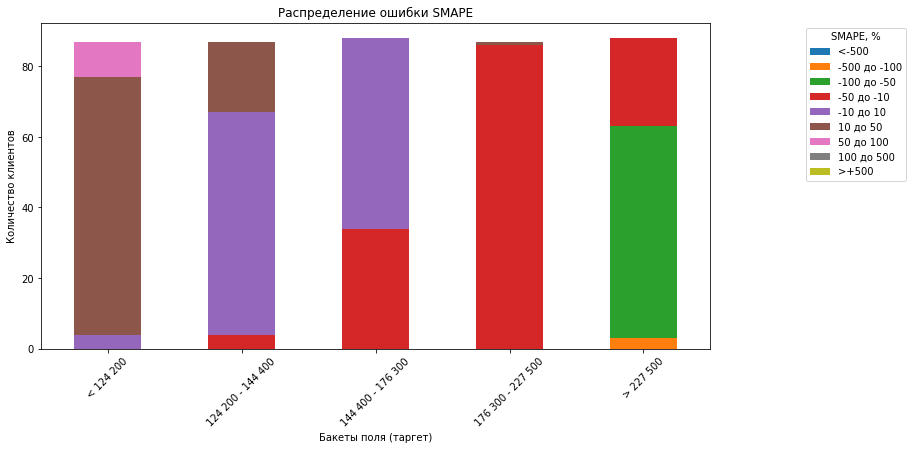

,target,target_range,prediction,smape,smape_range
0,154500,144 400 - 176 300,"141,763.42",-8.60,-10 до 10
1,325000,> 227 500,"153,676.84",-71.58,-100 до -50
2,115000,< 124 200,"142,453.28",21.33,10 до 50
3,159000,144 400 - 176 300,"146,948.43",-7.88,-10 до 10
4,315500,> 227 500,"153,218.09",-69.24,-100 до -50
...,...,...,...,...,...
433,139000,124 200 - 144 400,"141,988.21",2.13,-10 до 10
434,126175,124 200 - 144 400,"139,658.28",10.14,10 до 50
435,205950,176 300 - 227 500,"149,288.30",-31.90,-50 до -10
436,110000,< 124 200,"148,597.66",29.85,10 до 50


In [21]:
# Метрика SMAPE по бинам для теста

smape_te_table = final_model.metric_bin(X_val, y_val, 5, 'smape')
smape_te_table

In [22]:
final_model.get_pickles(
                columns=True,
                prep_pipe=True,
                model=True,
                calibration=False,
                path='final_results')

Директория существует


'Все атрибуты сохранены!'